<a href="https://colab.research.google.com/github/shuchimishra/Tensorflow_projects/blob/main/Tensorflow_Code/Timeseries/exam/Category5_Household_power_consumption_0.548_MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# release
# ==============================================================================
# There are 5 questions in this exam with increasing difficulty from 1-5.
# Please note that the weight of the grade for the question is relative to its
# difficulty. So your Category 1 question will score significantly less than
# your Category 5 question.
#
# WARNING: Do not use lambda layers in your model, they are not supported
# on the grading infrastructure. You do not need them to solve the question.
#
# WARNING: If you are using the GRU layer, it is advised not to use the
# recurrent_dropout argument (you can alternatively set it to 0),
# since it has not been implemented in the cuDNN kernel and may
# result in much longer training times.
#
# WARNING: Input and output shape requirements are laid down in the section
# 'INSTRUCTIONS' below and also reiterated in code comments.
# Please read them thoroughly. After submitting the trained model for scoring,
# if you are receiving a score of 0 or an error, please recheck the input and
# output shapes of the model to see if it exactly matches our requirements.
# Grading infrastrcuture is very strict about the shape requirements. Most common
# issues occur when the shapes are not matching our expectations.
#
# TIP: You can print the output of model.summary() to review the model
# architecture, input and output shapes of each layer.
# If you have made sure that you have matched the shape requirements
# and all the other instructions we have laid down, and still
# receive a bad score, you must work on improving your model.
#
# You must use the Submit and Test button to submit your model
# at least once in this category before you finally submit your exam,
# otherwise you will score zero for this category.

In [2]:
# ==============================================================================
#
# TIME SERIES QUESTION
#
# Build and train a neural network to predict time indexed variables of
# the multivariate house hold electric power consumption time series dataset.
# Using a window of past 24 observations of the 7 variables, the model
# should be trained to predict the next 24 observations of the 7 variables.
#
# ==============================================================================
#
# ABOUT THE DATASET
#
# Original Source:
# https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption
#
# The original Individual House Hold Electric Power Consumption Dataset
# has Measurements of electric power consumption in one household with
# a one-minute sampling rate over a period of almost 4 years.
#
# Different electrical quantities and some sub-metering values are available.
#
# For the purpose of the examination we have provided a subset containing
# the data for the first 60 days in the dataset. We have also cleaned the
# dataset beforehand to remove missing values. The dataset is provided as a
# CSV file in the project.
#
# The dataset has a total of 7 features ordered by time.
# ==============================================================================

In [3]:
#
# INSTRUCTIONS
#
# Complete the code in following functions:
# 1. solution_model()
#
# You may receive a score of 0 or your code will fail to be graded if the
# following criteria are not met:
#
# 1. Model input shape must be (BATCH_SIZE, N_PAST = 24, N_FEATURES = 7),
#    since the testing infrastructure expects a window of past N_PAST = 24
#    observations of the 7 features to predict the next N_FUTURE = 24
#    observations of the same features.
#
# 2. Model output shape must be (BATCH_SIZE, N_FUTURE = 24, N_FEATURES = 7)
#
# 3. The last layer of your model must be a Dense layer with 7 neurons since
#    the model is expected to predict observations of 7 features.
#
# 4. Don't change the values of the following constants:
#    SPLIT_TIME, N_FEATURES, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT, in
#    solution_model() (See code for additional note on BATCH_SIZE).
#
# 5. Code for normalizing the data is provided - don't change it.
#    Changing the normalizing code will affect your score.
#
# 6. Code for converting the dataset into windows is provided - don't change it.
#    Changing the windowing code will affect your score.
#
# 7. Code for setting the seed is provided - don't change it.
#
# Make sure that the model architecture and input, output shapes match our
# requirements by printing model.summary() and reviewing its output.
#

In [4]:
# HINT: If you follow all the rules mentioned above and throughout this
# question while training your neural network, there is a possibility that a
# validation MAE of approximately 0.055 or less on the normalized validation
# dataset may fetch you top marks.

In [5]:
import urllib
import zipfile

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np

In [6]:
# This function downloads and extracts the dataset to the directory that
# contains this file.
# DO NOT CHANGE THIS CODE
# (unless you need to change https to http)
def download_and_extract_data():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/certificate/household_power.zip'
    urllib.request.urlretrieve(url, 'household_power.zip')
    with zipfile.ZipFile('household_power.zip', 'r') as zip_ref:
        zip_ref.extractall()

In [7]:
# This function normalizes the dataset using min max scaling.
# DO NOT CHANGE THIS CODE
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

In [8]:
# This function is used to map the time series dataset into windows of
# features and respective targets, to prepare it for training and
# validation. First element of the first window will be the first element of
# the dataset. Consecutive windows are constructed by shifting
# the starting position of the first window forward, one at a time (indicated
# by shift=1). For a window of n_past number of observations of all the time
# indexed variables in the dataset, the target for the window
# is the next n_future number of observations of these variables, after the
# end of the window.

# DO NOT CHANGE THIS CODE
def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
# THIS CODE IS USED IN THE TESTER FOR FORECASTING. IF YOU WANT TO TEST YOUR MODEL
# BEFORE UPLOADING YOU CAN DO IT WITH THIS
def mae(y_true, y_pred):
   return np.mean(abs(y_true.ravel() - y_pred.ravel()))


def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [10]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs={}):
    if logs['val_mae'] < 0.0535:
      print("Stopping training since val loss is less than 0.0535")
      self.model.stop_training = True

In [11]:
# This function loads the data from CSV file, normalizes the data and
# splits the dataset into train and validation data. It also uses
# windowed_dataset() to split the data into windows of observations and
# targets. Finally it defines, compiles and trains a neural network. This
# function returns the final trained model.

# COMPLETE THE CODE IN THIS FUNCTION
def solution_model():
    # Downloads and extracts the dataset to the directory that
    # contains this file.
    download_and_extract_data()
    # Reads the dataset from the CSV.
    df = pd.read_csv('household_power_consumption.csv', sep=',',infer_datetime_format=True, index_col='datetime', header=0)

    # Number of features in the dataset. We use all features as predictors to
    # predict all features at future time steps.
    N_FEATURES = len(df.columns) # DO NOT CHANGE THIS

    # Normalizes the data
    data = df.values
    data = normalize_series(data, data.min(axis=0), data.max(axis=0))

    # Splits the data into training and validation sets.
    SPLIT_TIME = int(len(data) * 0.5) # DO NOT CHANGE THIS
    x_train = data[:SPLIT_TIME]
    x_valid = data[SPLIT_TIME:]

    # DO NOT CHANGE THIS CODE
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    # DO NOT CHANGE BATCH_SIZE IF YOU ARE USING STATEFUL LSTM/RNN/GRU.
    # THE TEST WILL FAIL TO GRADE YOUR SCORE IN SUCH CASES.
    # In other cases, it is advised not to change the batch size since it
    # might affect your final scores. While setting it to a lower size
    # might not do any harm, higher sizes might affect your scores.
    BATCH_SIZE = 32  # ADVISED NOT TO CHANGE THIS

    # DO NOT CHANGE N_PAST, N_FUTURE, SHIFT. The tests will fail to run
    # on the server.
    # Number of past time steps based on which future observations should be
    # predicted
    N_PAST = 24  # DO NOT CHANGE THIS

    # Number of future time steps which are to be predicted.
    N_FUTURE = 24  # DO NOT CHANGE THIS

    # By how many positions the window slides to create a new window
    # of observations.
    SHIFT = 1  # DO NOT CHANGE THIS

    # Code to create windowed train and validation datasets.
    train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
    valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)

    # Code to define your model.
    model = tf.keras.models.Sequential([

        # ADD YOUR LAYERS HERE.

        # If you don't follow the instructions in the following comments,
        # tests will fail to grade your code:
        # The input layer of your model must have an input shape of:
        # (BATCH_SIZE, N_PAST = 24, N_FEATURES = 7)
        # The model must have an output shape of:
        # (BATCH_SIZE, N_FUTURE = 24, N_FEATURES = 7).
        # Make sure that there are N_FEATURES = 7 neurons in the final dense
        # layer since the model predicts 7 features.

        # HINT: Bidirectional LSTMs may help boost your score. This is only a
        # suggestion.

        # WARNING: After submitting the trained model for scoring, if you are
        # receiving a score of 0 or an error, please recheck the input and
        # output shapes of the model to see if it exactly matches our requirements.
        # The grading infrastructure is very strict about the shape requirements.
        # Most common issues occur when the shapes are not matching our
        # expectations.
        #
        # TIP: You can print the output of model.summary() to review the model
        # architecture, input and output shapes of each layer.
        # If you have made sure that you have matched the shape requirements
        # and all the other instructions we have laid down, and still
        # receive a bad score, you must work on improving your model.

        # WARNING: If you are using the GRU layer, it is advised not to use the
        # recurrent_dropout argument (you can alternatively set it to 0),
        # since it has not been implemented in the cuDNN kernel and may
        # result in much longer training times.

        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[N_PAST, N_FEATURES]),

        tf.keras.layers.LSTM(128, return_sequences=True), #, input_shape=(N_PAST, N_FEATURES)
        tf.keras.layers.LSTM(128, return_sequences=True), #this is important to have output shape of batch_size, N_FUTURE, N_FEATURES
        # tf.keras.layers.LSTM(32, return_sequences=True),

        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(64),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(N_FEATURES)
        ])

    model.summary()

    # Initialize learning rate
    lr = 1e-3

    # Initialize the optimizer
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr,clipnorm=1) #clipnorm to avoid nan (exploding gradient problem)

    # Set the training parameters
    model.compile(loss=keras.losses.mean_absolute_error, optimizer=optimizer, metrics=['mae'])

    #callback
    callback = MyCallback()
    RLP = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mae",patience=3, verbose=1,mode="auto")
    ES = tf.keras.callbacks.EarlyStopping(monitor="val_mae",patience=5, verbose=1, mode="auto", start_from_epoch=10)

    # Train the model
    history = model.fit(train_set, epochs=500, validation_data=valid_set, verbose = 2, callbacks=[ES,RLP]) #batch_size=32,


    # PASS THE NORMALIZED data IN THE FOLLOWING CODE
    rnn_forecast = model_forecast(model, data, N_PAST, BATCH_SIZE)
    rnn_forecast = rnn_forecast[SPLIT_TIME - N_PAST:-1, 0, :]
    x_valid = x_valid[:rnn_forecast.shape[0]]
    result = mae(x_valid, rnn_forecast)
    print("Result is :", result) #0.05489

    return model

# Note that you'll need to save your model as a .h5 like this.
# When you press the Submit and Test button, your saved .h5 model will
# be sent to the testing infrastructure for scoring
# and the score will be returned to you.

if __name__ == '__main__':
    model = solution_model()
    model.save("mymodel.h5")

<ipython-input-11-a8cd97a70ef4>:13: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.csv', sep=',',infer_datetime_format=True, index_col='datetime', header=0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 128)           4608      
                                                                 
 lstm (LSTM)                 (None, 24, 128)           131584    
                                                                 
 lstm_1 (LSTM)               (None, 24, 128)           131584    
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 dense (Dense)               (None, 24, 64)            8256      
                                                                 
 dense_1 (Dense)             (None, 24, 7)             455       
                                                                 
Total params: 276487 (1.05 MB)
Trainable params: 276487 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
# download_and_extract_data()
# # Reads the dataset from the CSV.
# df = pd.read_csv('household_power_consumption.csv', sep=',',infer_datetime_format=True, index_col='datetime', header=0)

<ipython-input-5-13cc74b8af44>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.csv', sep=',',infer_datetime_format=True, index_col='datetime', header=0)


In [6]:
# df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
# N_FEATURES = len(df.columns)
# print(N_FEATURES)

7


In [8]:
# # Normalizes the data
# data = df.values
# data = normalize_series(data, data.min(axis=0), data.max(axis=0))
# # #check if there are any nan's
# # print(np.any(np.isnan(data)))

In [9]:
# # Splits the data into training and validation sets.
# SPLIT_TIME = int(len(data) * 0.5) # DO NOT CHANGE THIS
# x_train = data[:SPLIT_TIME]
# x_valid = data[SPLIT_TIME:]

In [10]:
# tf.keras.backend.clear_session()
# tf.random.set_seed(42)

In [11]:
# BATCH_SIZE = 32
# N_PAST = 24
# N_FUTURE = 24
# SHIFT = 1

In [12]:
# # Code to create windowed train and validation datasets.
# train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,n_past=N_PAST, n_future=N_FUTURE,shift=SHIFT)

# valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,n_past=N_PAST, n_future=N_FUTURE,shift=SHIFT)

In [13]:
# print(train_set)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None))>


In [17]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[N_PAST, N_FEATURES]),
#     tf.keras.layers.LSTM(128, return_sequences=True), #, input_shape=(N_PAST, N_FEATURES)
#     tf.keras.layers.LSTM(128, return_sequences=True),
#     # tf.keras.layers.LSTM(32, return_sequences=True),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(64),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(N_FEATURES)
#     ])

# model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 24, 128)           4608      
                                                                 
 lstm_2 (LSTM)               (None, 24, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 24, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 24, 128)           0         
                                                                 
 dense_2 (Dense)             (None, 24, 64)            8256      
                                                                 
 dense_3 (Dense)             (None, 24, 7)             455       
                                                                 
Total params: 276487 (1.05 MB)
Trainable params: 27648

In [ ]:
# # Set the learning rate scheduler
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# # Code to train and compile the model
# optimizer =  optimizer=tf.keras.optimizers.SGD(momentum=0.9) # YOUR CODE HERE

# model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer)

# history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

(0.001, 10.0, 0.01, 0.03)

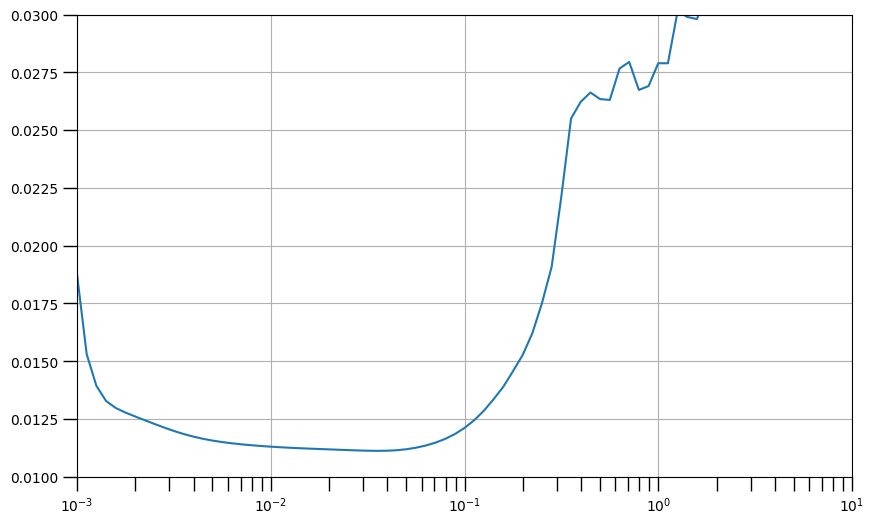

In [31]:
# # Tune the learning rate array
# lrs = 1e-3 * (10 ** (np.arange(100) / 20))

# # Set the figure size
# plt.figure(figsize=(10, 6))

# # Set the grid
# plt.grid(True)

# # Plot the loss in log scale
# plt.semilogx(lrs, history.history["loss"])

# # Increase the tickmarks size
# plt.tick_params('both', length=10, width=1, which='both')

# # Set the plot boundaries
# plt.axis([1e-3, 1e1, 0.01, 0.03])

In [15]:
# class MyCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epochs, logs={}):
#     if logs['val_mae'] < 0.0535:
#       print("Stopping training since val loss is less than 0.0535")
#       self.model.stop_training = True

In [18]:
# # Initialize learning rate
# lr = 1e-3 #5e-2

# # Initialize the optimizer
# # optimizer = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=lr)

# optimizer=tf.keras.optimizers.Adam(
#     learning_rate=lr,
#     clipnorm=1)


# # Set the training parameters
# # model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae','mse'])
# model.compile(loss=keras.losses.mean_absolute_error, optimizer=optimizer, metrics=['mae'])

# #callback
# callback = MyCallback()

# RLP = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_mae",
#     patience=3, #5
#     verbose=1,
#     mode="auto"
# )

# ES = tf.keras.callbacks.EarlyStopping(
#     monitor="val_mae",
#     patience=5, #15
#     verbose=1,
#     mode="auto",
#     start_from_epoch=10
# )

# # Train the model
# history = model.fit(train_set, epochs=500, validation_data=valid_set, verbose = 2, callbacks=[ES,RLP]) #batch_size=32,

Epoch 1/500
1349/1349 - 19s - loss: 0.0809 - mae: 0.0809 - val_loss: 0.0685 - val_mae: 0.0685 - lr: 0.0010 - 19s/epoch - 14ms/step
Epoch 2/500
1349/1349 - 14s - loss: 0.0700 - mae: 0.0700 - val_loss: 0.0680 - val_mae: 0.0680 - lr: 0.0010 - 14s/epoch - 11ms/step
Epoch 3/500
1349/1349 - 14s - loss: 0.0664 - mae: 0.0664 - val_loss: 0.0647 - val_mae: 0.0647 - lr: 0.0010 - 14s/epoch - 11ms/step
Epoch 4/500
1349/1349 - 15s - loss: 0.0643 - mae: 0.0643 - val_loss: 0.0638 - val_mae: 0.0638 - lr: 0.0010 - 15s/epoch - 11ms/step
Epoch 5/500
1349/1349 - 15s - loss: 0.0632 - mae: 0.0632 - val_loss: 0.0629 - val_mae: 0.0629 - lr: 0.0010 - 15s/epoch - 11ms/step
Epoch 6/500
1349/1349 - 15s - loss: 0.0623 - mae: 0.0623 - val_loss: 0.0619 - val_mae: 0.0619 - lr: 0.0010 - 15s/epoch - 11ms/step
Epoch 7/500
1349/1349 - 14s - loss: 0.0616 - mae: 0.0616 - val_loss: 0.0600 - val_mae: 0.0600 - lr: 0.0010 - 14s/epoch - 11ms/step
Epoch 8/500
1349/1349 - 15s - loss: 0.0610 - mae: 0.0610 - val_loss: 0.0596 - val_m

In [20]:
# # Auxiliary plotting function
# def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None ):
#     plt.figure(figsize=(10, 6))
#     if type(y) is tuple:
#         for y_curr in y:
#             plt.plot(x[start:end], y_curr[start:end], format)
#     else:
#         plt.plot(x[start:end], y[start:end], format)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     if legend:
#         plt.legend(legend)
#     plt.title(title)
#     plt.grid(True)
#     plt.show()

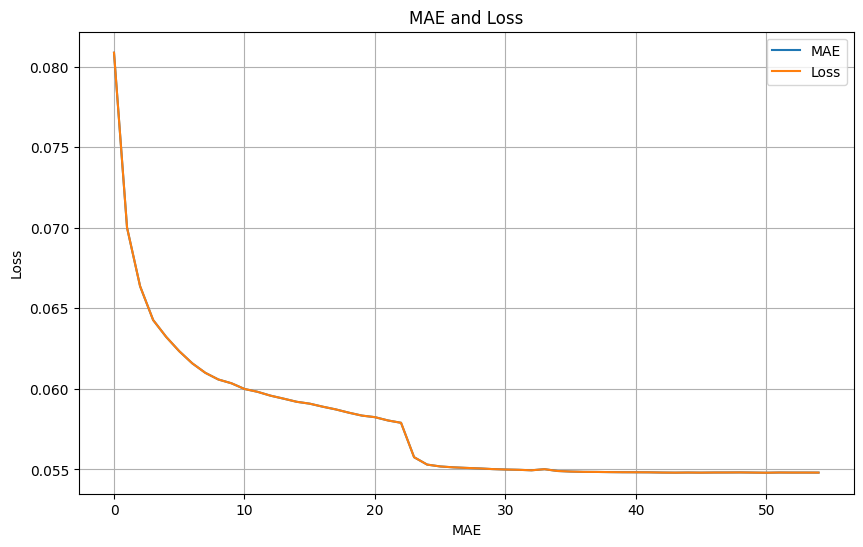

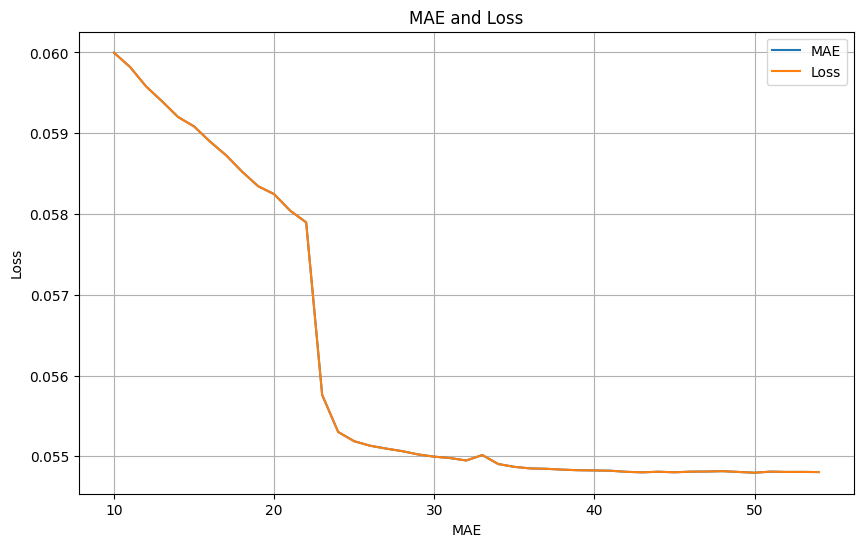

In [21]:
# # Get mae and loss from history log
# mae=history.history['mae']
# loss=history.history['loss']

# # Get number of epochs
# epochs=range(len(loss))


# # Plot mae and loss
# plot_series(
#     x=epochs,
#     y=(mae, loss),
#     title='MAE and Loss',
#     xlabel='MAE',
#     ylabel='Loss',
#     legend=['MAE', 'Loss']
#     )

# # print(int(epochs[-1]*0.2))
# # Only plot the last 80% of the epochs
# zoom_split = int(epochs[-1] * 0.2)
# epochs_zoom = epochs[zoom_split:]
# mae_zoom = mae[zoom_split:]
# loss_zoom = loss[zoom_split:]

# # Plot zoomed mae and loss
# plot_series(
#     x=epochs_zoom,
#     y=(mae_zoom, loss_zoom),
#     title='MAE and Loss',
#     xlabel='MAE',
#     ylabel='Loss',
#     legend=['MAE', 'Loss']
#     )

In [22]:
# # THIS CODE IS USED IN THE TESTER FOR FORECASTING. IF YOU WANT TO TEST YOUR MODEL
# # BEFORE UPLOADING YOU CAN DO IT WITH THIS
# def mae(y_true, y_pred):
#    return np.mean(abs(y_true.ravel() - y_pred.ravel()))


# def model_forecast(model, series, window_size, batch_size):
#    ds = tf.data.Dataset.from_tensor_slices(series)
#    ds = ds.window(window_size, shift=1, drop_remainder=True)
#    ds = ds.flat_map(lambda w: w.batch(window_size))
#    ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
#    forecast = model.predict(ds)
#    return forecast

In [23]:
# # PASS THE NORMALIZED data IN THE FOLLOWING CODE

# rnn_forecast = model_forecast(model, data, N_PAST, BATCH_SIZE)
# rnn_forecast = rnn_forecast[SPLIT_TIME - N_PAST:-1, 0, :]

2699/2699 [==============================] - 9s 3ms/step


In [24]:
# x_valid = x_valid[:rnn_forecast.shape[0]]
# result = mae(x_valid, rnn_forecast)

In [25]:
# print(result)

0.054894517397087964


In [26]:
# model.save("mymodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
